In [1]:
import torch
print(torch.__version__)

2.0.1


In [2]:
# Load Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet

data = MoleculeNet(root=".", name="ESOL")
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 32
loader = DataLoader(data[:int(data_size * 0.7)], batch_size=NUM_GRAPHS_PER_BATCH, shuffle = False)
test_loader = DataLoader(data[int(data_size * 0.7):int(data_size * 0.9)], batch_size=NUM_GRAPHS_PER_BATCH, shuffle = False)


C:\Users\illew\anaconda3\envs\rdkit_tf-gpu\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [3]:
# Embed SMILES into numbers

# Get set of characters
chars = set()
for i in data.smiles:
    for letter in i:
        chars.add(letter) 
chars = ['.']+sorted(list(chars))
vocab_size = len(chars)+1 #plus one for padding "end" type char
print('Vocabulary:')
print(''.join(chars))
print(vocab_size)

# Map characters to integers
stoi = {ch:i+1 for i,ch in enumerate(chars)}
itos = {i+1:ch for i,ch in enumerate(chars)}
encode = lambda st: [stoi[ch] for ch in st]
decode = lambda nu: ''.join([itos[int(i)] for i in nu])
print('Encoding Test:')
print(encode('Cc1occc1C(=O)Nc2ccccc2'))
print(decode(encode('Cc1occc1C(=O)Nc2ccccc2')))

Vocabulary:
. #()/12345678=BCFHINOPS[\]clnors
34
Encoding Test:
[17, 28, 7, 31, 28, 28, 28, 7, 17, 4, 15, 22, 5, 21, 28, 8, 28, 28, 28, 28, 28, 8]
Cc1occc1C(=O)Nc2ccccc2


In [4]:
# Get max length for padding
max_length = 0
for i in data.smiles:
    if len(i)>max_length:
        max_length = len(i)
print(max_length)

98


In [5]:
# Add padded encodings to dataset
def add_attributes(dataset):
    data_list = []
    for data in dataset:
        data.encsmiles = encode(data.smiles)+[0 for _ in range(len(encode(data.smiles)),max_length)]
        data_list.append(data)
    dataset.data, dataset.slices = dataset.collate(data_list)
    return dataset

data = add_attributes(data)

In [6]:
# Check encoded smiles
print(len(data[0].encsmiles))
print(data[0].encsmiles)
print(data[0].y)

98
[22, 17, 17, 9, 22, 17, 4, 22, 17, 17, 8, 22, 17, 4, 22, 17, 4, 17, 3, 21, 5, 28, 7, 28, 28, 28, 28, 28, 7, 5, 17, 4, 22, 5, 17, 4, 22, 5, 17, 8, 22, 5, 17, 4, 22, 5, 17, 4, 22, 5, 17, 9, 22, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([[-0.7700]])


In [7]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Linear
torch.manual_seed(1234)

torch.set_default_tensor_type(torch.cuda.FloatTensor)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = max_length):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))

        pe = torch.zeros(1, max_len, d_model) # Batch, Token, Channel 
        pe[0,:,0::2] = torch.sin(position*div_term)
        pe[0,:,1::2] = torch.cos(position*div_term) 
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "model dimensionality must be divisible by number of heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # dimensions per head
        
        self.W_q = nn.Linear(d_model,d_model)
        self.W_k = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model,d_model)
        self.W_o = nn.Linear(d_model,d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Get similarities between queries and keys
        attention_scores = Q @ K.transpose(-2,-1) / math.sqrt(self.d_k)
        
        # Mask if present
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax to get proportional weights for value aggregation
        attention_probability = torch.softmax(attention_scores, dim=-1)
        output_values = attention_probability @ V
        return output_values
    
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1,2)
    
    def combine_heads(self, x):
        batch_size, heads, seq_length, d_k = x.size()
        return x.transpose(1,2).contiguous().view(batch_size, seq_length, self.d_model)
    
    def forward(self, embedding, mask=None):
        # Multi head split
        Q = self.split_heads(self.W_q(embedding))
        K = self.split_heads(self.W_k(embedding))
        V = self.split_heads(self.W_v(embedding))
        
        # Attention
        attention_output = self.scaled_dot_product_attention(Q,K,V, mask)
        
        # Merge heads and output
        output = self.W_o(self.combine_heads(attention_output))
        return output
    
class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, vocab_size, dropout=0.1):
        super(Encoder,self).__init__()
        # Embedding
        self.embedding = nn.Embedding(vocab_size,d_model)
        
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Attention
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        
        # Linear
        self.linear = Linear(max_length*d_model, 1)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, idx, targets=None):
        # Embedding
        logits = self.embedding(idx) # (B,T,C)
        
        # Positional Encoding 
        logits = self.pos_encoder(logits)
        
        # Attention
        attend = self.self_attention(logits)
        
        # Residual Connection
        logits = logits + self.dropout(attend)
        logits = self.norm(logits)
        
        # Output
        batch_size, seq_length, d_model = logits.size()
        logits = logits.contiguous().view(batch_size, seq_length*d_model)
        output = self.linear(logits)
        loss = F.mse_loss(output,targets)    
        return output, loss 

# Initialize Model
emb_size = 32
num_heads = emb_size//8
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
m = Encoder(emb_size, num_heads, vocab_size).to(device)
print("Number of Parameters: ", sum(p.numel() for p in m.parameters()))

Number of Parameters:  8513


In [8]:
# Data loader
batch_size = 32
loader = DataLoader(data[:int(data_size * 0.7)], batch_size=batch_size, shuffle = False)
test_loader = DataLoader(data[int(data_size * 0.7):int(data_size * 0.9)], batch_size=batch_size, shuffle = False)
val_loader = DataLoader(data[int(data_size * 0.9):], batch_size=batch_size, shuffle = False)

In [9]:
# Training Loop
optimizer = torch.optim.Adam(m.parameters(), lr=0.01)
losses = []
val_losses = []
for epoch in range(3000):
    for batch in loader:
        
        # Forward pass
        batch = batch.to(device)
        property_prediction, loss = m(torch.tensor(batch.encsmiles), batch.y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update
        optimizer.step()
    
    # Validation
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            val_property_prediction, val_loss = m(torch.tensor(batch.encsmiles), batch.y)
            break # Just check first batch
    
    # Documentation
    val_losses.append(val_loss)
    losses.append(loss)
    print(epoch, 'loss:{:0.5f} val_loss:{:0.5f} pred:{:0.5f},{:0.5f} real:{:0.5f},{:0.5f}'.format(loss.item(), val_loss.item(), property_prediction[0].item(),property_prediction[-1].item(),batch.y[0].item(),batch.y[-1].item()) )
   
    if val_loss == min(val_losses):
        torch.save(m,'26092023val_aenc.pt')


0 loss:2.25423 val_loss:3.75890 pred:-4.78576,-3.93613 real:-6.68000,-6.86000
1 loss:1.69789 val_loss:2.07823 pred:-5.56911,-5.65857 real:-6.68000,-6.86000
2 loss:1.23670 val_loss:1.54159 pred:-5.97370,-5.70363 real:-6.68000,-6.86000
3 loss:1.00770 val_loss:1.12116 pred:-6.37030,-5.99838 real:-6.68000,-6.86000
4 loss:0.94001 val_loss:1.14728 pred:-5.86646,-5.80798 real:-6.68000,-6.86000
5 loss:1.01384 val_loss:1.20672 pred:-5.44098,-6.21238 real:-6.68000,-6.86000
6 loss:1.00483 val_loss:0.87801 pred:-5.20054,-5.12412 real:-6.68000,-6.86000
7 loss:1.03856 val_loss:1.17620 pred:-5.32704,-5.18776 real:-6.68000,-6.86000
8 loss:0.68319 val_loss:1.08068 pred:-6.03416,-6.24264 real:-6.68000,-6.86000
9 loss:0.55178 val_loss:1.25240 pred:-5.57673,-7.58121 real:-6.68000,-6.86000
10 loss:0.97801 val_loss:1.16076 pred:-6.54956,-6.94589 real:-6.68000,-6.86000
11 loss:1.06100 val_loss:2.25878 pred:-5.89986,-7.17305 real:-6.68000,-6.86000
12 loss:0.89726 val_loss:1.50352 pred:-4.74350,-6.43226 real:-

104 loss:0.09387 val_loss:1.05311 pred:-6.17770,-8.71714 real:-6.68000,-6.86000
105 loss:0.17319 val_loss:0.97365 pred:-5.74364,-7.54998 real:-6.68000,-6.86000
106 loss:0.12749 val_loss:0.85847 pred:-6.68474,-7.77769 real:-6.68000,-6.86000
107 loss:0.12298 val_loss:0.88863 pred:-6.43180,-7.57173 real:-6.68000,-6.86000
108 loss:0.13904 val_loss:0.89314 pred:-6.15171,-7.62421 real:-6.68000,-6.86000
109 loss:0.24651 val_loss:1.07292 pred:-6.03381,-6.95701 real:-6.68000,-6.86000
110 loss:0.14296 val_loss:1.09397 pred:-6.09195,-7.95884 real:-6.68000,-6.86000
111 loss:0.38249 val_loss:0.85944 pred:-5.31710,-6.81933 real:-6.68000,-6.86000
112 loss:0.17255 val_loss:0.87429 pred:-6.09308,-8.38577 real:-6.68000,-6.86000
113 loss:0.22073 val_loss:1.02439 pred:-5.51766,-7.05821 real:-6.68000,-6.86000
114 loss:0.13959 val_loss:0.89757 pred:-5.99522,-7.98263 real:-6.68000,-6.86000
115 loss:0.30374 val_loss:0.77007 pred:-5.97562,-6.92055 real:-6.68000,-6.86000
116 loss:0.26550 val_loss:1.06699 pred:-

207 loss:0.11981 val_loss:0.91966 pred:-6.69741,-8.30021 real:-6.68000,-6.86000
208 loss:0.16073 val_loss:1.17380 pred:-6.09253,-7.17475 real:-6.68000,-6.86000
209 loss:0.10076 val_loss:1.26203 pred:-6.44432,-8.13382 real:-6.68000,-6.86000
210 loss:0.12843 val_loss:1.09546 pred:-6.23036,-8.48309 real:-6.68000,-6.86000
211 loss:0.09245 val_loss:1.05940 pred:-6.28668,-8.70059 real:-6.68000,-6.86000
212 loss:0.11647 val_loss:1.09516 pred:-5.87055,-7.61881 real:-6.68000,-6.86000
213 loss:0.25469 val_loss:1.01135 pred:-6.17974,-7.48535 real:-6.68000,-6.86000
214 loss:0.12592 val_loss:1.23986 pred:-6.41908,-7.79775 real:-6.68000,-6.86000
215 loss:0.17145 val_loss:1.19297 pred:-5.85259,-7.68908 real:-6.68000,-6.86000
216 loss:0.08137 val_loss:1.22904 pred:-5.98337,-8.34973 real:-6.68000,-6.86000
217 loss:0.10505 val_loss:1.34978 pred:-6.17206,-7.96326 real:-6.68000,-6.86000
218 loss:0.16146 val_loss:1.35263 pred:-6.02212,-7.74461 real:-6.68000,-6.86000
219 loss:0.12379 val_loss:1.10019 pred:-

310 loss:0.11148 val_loss:0.76743 pred:-5.76446,-7.95926 real:-6.68000,-6.86000
311 loss:0.12379 val_loss:0.83838 pred:-5.91294,-8.17101 real:-6.68000,-6.86000
312 loss:0.11906 val_loss:1.06539 pred:-6.00053,-8.55774 real:-6.68000,-6.86000
313 loss:0.22352 val_loss:1.02229 pred:-5.85843,-7.04013 real:-6.68000,-6.86000
314 loss:0.08014 val_loss:0.83586 pred:-6.11023,-7.61107 real:-6.68000,-6.86000
315 loss:0.18044 val_loss:0.92541 pred:-6.21817,-8.53930 real:-6.68000,-6.86000
316 loss:0.19316 val_loss:1.01548 pred:-6.01504,-7.70038 real:-6.68000,-6.86000
317 loss:0.15610 val_loss:0.86651 pred:-6.49750,-8.04174 real:-6.68000,-6.86000
318 loss:0.21115 val_loss:0.84933 pred:-7.25797,-7.84010 real:-6.68000,-6.86000
319 loss:0.27144 val_loss:0.84590 pred:-7.01854,-6.84492 real:-6.68000,-6.86000
320 loss:0.34751 val_loss:0.87077 pred:-5.34974,-7.05431 real:-6.68000,-6.86000
321 loss:0.15479 val_loss:0.85821 pred:-5.68937,-7.62895 real:-6.68000,-6.86000
322 loss:0.11120 val_loss:1.11954 pred:-

413 loss:0.14211 val_loss:0.91882 pred:-5.61932,-8.00634 real:-6.68000,-6.86000
414 loss:0.10332 val_loss:0.80422 pred:-5.83054,-8.32759 real:-6.68000,-6.86000
415 loss:0.25871 val_loss:0.88695 pred:-5.80200,-7.22930 real:-6.68000,-6.86000
416 loss:0.09190 val_loss:0.92868 pred:-5.93245,-8.72704 real:-6.68000,-6.86000
417 loss:0.47049 val_loss:1.03508 pred:-5.51342,-6.18867 real:-6.68000,-6.86000
418 loss:0.17417 val_loss:0.91094 pred:-5.61086,-7.12742 real:-6.68000,-6.86000
419 loss:0.30364 val_loss:1.14052 pred:-4.96620,-7.16726 real:-6.68000,-6.86000
420 loss:0.30451 val_loss:0.75370 pred:-5.87202,-6.69933 real:-6.68000,-6.86000
421 loss:0.25157 val_loss:0.95388 pred:-6.36128,-6.91493 real:-6.68000,-6.86000
422 loss:0.12408 val_loss:0.99557 pred:-6.24650,-7.97823 real:-6.68000,-6.86000
423 loss:0.35826 val_loss:1.17678 pred:-6.14026,-6.31559 real:-6.68000,-6.86000
424 loss:0.10961 val_loss:0.88518 pred:-5.80245,-7.80484 real:-6.68000,-6.86000
425 loss:0.24976 val_loss:0.83983 pred:-

516 loss:0.30855 val_loss:0.94639 pred:-6.57922,-7.39941 real:-6.68000,-6.86000
517 loss:0.11853 val_loss:0.81814 pred:-6.02156,-8.18738 real:-6.68000,-6.86000
518 loss:0.08117 val_loss:0.77633 pred:-5.94864,-8.14826 real:-6.68000,-6.86000
519 loss:0.20363 val_loss:0.95780 pred:-6.00072,-7.95701 real:-6.68000,-6.86000
520 loss:0.27153 val_loss:0.82772 pred:-5.69636,-7.03612 real:-6.68000,-6.86000
521 loss:0.11071 val_loss:0.96778 pred:-5.75678,-8.27719 real:-6.68000,-6.86000
522 loss:0.14541 val_loss:0.84420 pred:-6.45758,-7.88660 real:-6.68000,-6.86000
523 loss:0.16165 val_loss:0.97915 pred:-6.05336,-7.92213 real:-6.68000,-6.86000
524 loss:0.23601 val_loss:1.03173 pred:-6.32676,-8.92937 real:-6.68000,-6.86000
525 loss:0.21811 val_loss:0.94418 pred:-6.78303,-7.70003 real:-6.68000,-6.86000
526 loss:0.14657 val_loss:1.03010 pred:-5.60934,-8.03499 real:-6.68000,-6.86000
527 loss:0.24369 val_loss:1.03461 pred:-6.34546,-6.87314 real:-6.68000,-6.86000
528 loss:0.17781 val_loss:0.93960 pred:-

619 loss:0.12419 val_loss:0.97326 pred:-6.64118,-7.94126 real:-6.68000,-6.86000
620 loss:0.15540 val_loss:0.87198 pred:-5.79756,-7.23648 real:-6.68000,-6.86000
621 loss:0.16679 val_loss:0.62013 pred:-5.54520,-8.39306 real:-6.68000,-6.86000
622 loss:0.12756 val_loss:0.96512 pred:-6.55399,-7.86667 real:-6.68000,-6.86000
623 loss:0.20009 val_loss:1.08576 pred:-5.80866,-7.75911 real:-6.68000,-6.86000
624 loss:0.14906 val_loss:0.99411 pred:-5.78482,-7.78251 real:-6.68000,-6.86000
625 loss:0.10974 val_loss:1.17876 pred:-6.15844,-8.89562 real:-6.68000,-6.86000
626 loss:0.17037 val_loss:0.91041 pred:-5.88608,-7.86584 real:-6.68000,-6.86000
627 loss:0.18028 val_loss:0.98750 pred:-5.77790,-7.91240 real:-6.68000,-6.86000
628 loss:0.14190 val_loss:1.06971 pred:-5.78891,-7.56194 real:-6.68000,-6.86000
629 loss:0.16516 val_loss:0.83990 pred:-6.12184,-8.01968 real:-6.68000,-6.86000
630 loss:0.16653 val_loss:0.95908 pred:-6.18392,-8.17427 real:-6.68000,-6.86000
631 loss:0.10446 val_loss:0.81762 pred:-

722 loss:0.12782 val_loss:0.98803 pred:-6.30381,-8.08811 real:-6.68000,-6.86000
723 loss:0.14120 val_loss:1.07833 pred:-6.23933,-7.60104 real:-6.68000,-6.86000
724 loss:0.12608 val_loss:1.01282 pred:-5.72735,-8.06703 real:-6.68000,-6.86000
725 loss:0.23622 val_loss:1.03022 pred:-6.00644,-8.11853 real:-6.68000,-6.86000
726 loss:0.32167 val_loss:1.08092 pred:-5.80808,-7.26615 real:-6.68000,-6.86000
727 loss:0.11167 val_loss:0.92364 pred:-6.62256,-8.00521 real:-6.68000,-6.86000
728 loss:0.07117 val_loss:0.84746 pred:-6.53157,-8.68589 real:-6.68000,-6.86000
729 loss:0.12329 val_loss:1.11453 pred:-6.54654,-7.73142 real:-6.68000,-6.86000
730 loss:0.15671 val_loss:0.94612 pred:-6.16707,-7.72145 real:-6.68000,-6.86000
731 loss:0.20542 val_loss:0.89191 pred:-5.96665,-7.75234 real:-6.68000,-6.86000
732 loss:0.21567 val_loss:0.82475 pred:-6.24208,-7.18481 real:-6.68000,-6.86000
733 loss:0.15049 val_loss:0.84083 pred:-6.25610,-7.89251 real:-6.68000,-6.86000
734 loss:0.17903 val_loss:0.96904 pred:-

825 loss:0.10608 val_loss:0.77932 pred:-6.07601,-7.87184 real:-6.68000,-6.86000
826 loss:0.24173 val_loss:1.10574 pred:-5.82622,-7.30731 real:-6.68000,-6.86000
827 loss:0.16604 val_loss:0.87896 pred:-5.97339,-8.09021 real:-6.68000,-6.86000
828 loss:0.22973 val_loss:0.76663 pred:-6.49128,-8.67953 real:-6.68000,-6.86000
829 loss:0.16438 val_loss:0.87606 pred:-6.65474,-8.12384 real:-6.68000,-6.86000
830 loss:0.09403 val_loss:1.04339 pred:-6.61238,-7.98131 real:-6.68000,-6.86000
831 loss:0.12143 val_loss:0.84341 pred:-6.35146,-7.64092 real:-6.68000,-6.86000
832 loss:0.18469 val_loss:0.89981 pred:-5.97303,-8.36369 real:-6.68000,-6.86000
833 loss:0.17774 val_loss:0.97865 pred:-6.25336,-7.40191 real:-6.68000,-6.86000
834 loss:0.17428 val_loss:0.84949 pred:-6.08660,-7.54191 real:-6.68000,-6.86000
835 loss:0.11124 val_loss:0.88486 pred:-6.24856,-8.01671 real:-6.68000,-6.86000
836 loss:0.09433 val_loss:0.86117 pred:-6.18109,-8.33799 real:-6.68000,-6.86000
837 loss:0.13417 val_loss:0.91188 pred:-

928 loss:0.23246 val_loss:1.27276 pred:-6.13815,-6.98259 real:-6.68000,-6.86000
929 loss:0.21478 val_loss:0.89129 pred:-6.56112,-9.08680 real:-6.68000,-6.86000
930 loss:0.17194 val_loss:1.13501 pred:-7.17149,-8.18615 real:-6.68000,-6.86000
931 loss:0.19661 val_loss:1.08512 pred:-5.89723,-7.44059 real:-6.68000,-6.86000
932 loss:0.10625 val_loss:1.19267 pred:-6.06092,-8.26476 real:-6.68000,-6.86000
933 loss:0.18888 val_loss:0.87361 pred:-6.31884,-8.46468 real:-6.68000,-6.86000
934 loss:0.15585 val_loss:0.90793 pred:-6.52210,-7.37928 real:-6.68000,-6.86000
935 loss:0.26579 val_loss:1.00741 pred:-5.78234,-7.61863 real:-6.68000,-6.86000
936 loss:0.11659 val_loss:0.95646 pred:-6.02098,-7.81183 real:-6.68000,-6.86000
937 loss:0.10992 val_loss:0.92507 pred:-6.18899,-8.11975 real:-6.68000,-6.86000
938 loss:0.09555 val_loss:1.05421 pred:-5.70631,-7.73230 real:-6.68000,-6.86000
939 loss:0.24695 val_loss:0.92557 pred:-6.14414,-6.95663 real:-6.68000,-6.86000
940 loss:0.13002 val_loss:0.85799 pred:-

1031 loss:0.19411 val_loss:1.10165 pred:-5.95269,-8.97806 real:-6.68000,-6.86000
1032 loss:0.20415 val_loss:1.19813 pred:-5.65694,-7.24471 real:-6.68000,-6.86000
1033 loss:0.24443 val_loss:0.80790 pred:-5.77056,-7.85735 real:-6.68000,-6.86000
1034 loss:0.14197 val_loss:0.93320 pred:-5.69540,-7.78380 real:-6.68000,-6.86000
1035 loss:0.20556 val_loss:0.82805 pred:-5.60667,-7.30178 real:-6.68000,-6.86000
1036 loss:0.09983 val_loss:0.88298 pred:-6.05192,-7.93681 real:-6.68000,-6.86000
1037 loss:0.21609 val_loss:0.96204 pred:-6.24912,-8.78393 real:-6.68000,-6.86000
1038 loss:0.11047 val_loss:1.20297 pred:-6.39873,-8.01914 real:-6.68000,-6.86000
1039 loss:0.12312 val_loss:0.99225 pred:-6.14500,-7.90937 real:-6.68000,-6.86000
1040 loss:0.13273 val_loss:0.87655 pred:-5.79634,-7.76835 real:-6.68000,-6.86000
1041 loss:0.21758 val_loss:1.08596 pred:-6.26453,-7.96755 real:-6.68000,-6.86000
1042 loss:0.11703 val_loss:0.97826 pred:-5.72015,-8.36375 real:-6.68000,-6.86000
1043 loss:0.16679 val_loss:1

1133 loss:0.24740 val_loss:0.95774 pred:-5.63781,-7.44578 real:-6.68000,-6.86000
1134 loss:0.10571 val_loss:0.91910 pred:-6.13867,-8.22669 real:-6.68000,-6.86000
1135 loss:0.33341 val_loss:0.92833 pred:-6.07012,-6.42425 real:-6.68000,-6.86000
1136 loss:0.17162 val_loss:0.92163 pred:-5.77199,-7.66179 real:-6.68000,-6.86000
1137 loss:0.20451 val_loss:1.13809 pred:-6.41983,-8.75712 real:-6.68000,-6.86000
1138 loss:0.26508 val_loss:1.14375 pred:-5.48032,-7.67452 real:-6.68000,-6.86000
1139 loss:0.22692 val_loss:0.84661 pred:-6.08566,-8.00889 real:-6.68000,-6.86000
1140 loss:0.19602 val_loss:1.12596 pred:-6.27119,-8.36847 real:-6.68000,-6.86000
1141 loss:0.15864 val_loss:1.03266 pred:-6.09262,-9.35619 real:-6.68000,-6.86000
1142 loss:0.29931 val_loss:0.94718 pred:-6.08576,-6.71097 real:-6.68000,-6.86000
1143 loss:0.14959 val_loss:0.75327 pred:-6.42284,-9.00554 real:-6.68000,-6.86000
1144 loss:0.16328 val_loss:1.15964 pred:-6.16315,-7.82555 real:-6.68000,-6.86000
1145 loss:0.14284 val_loss:0

1235 loss:0.21676 val_loss:1.34778 pred:-5.94736,-6.79677 real:-6.68000,-6.86000
1236 loss:0.23911 val_loss:1.03505 pred:-5.32704,-8.87590 real:-6.68000,-6.86000
1237 loss:0.39343 val_loss:0.79894 pred:-5.60526,-7.07119 real:-6.68000,-6.86000
1238 loss:0.24304 val_loss:0.94112 pred:-5.63169,-7.99258 real:-6.68000,-6.86000
1239 loss:0.19407 val_loss:0.90085 pred:-5.81051,-8.22622 real:-6.68000,-6.86000
1240 loss:0.17839 val_loss:0.94288 pred:-6.11738,-7.54855 real:-6.68000,-6.86000
1241 loss:0.11535 val_loss:1.02121 pred:-6.22781,-8.64365 real:-6.68000,-6.86000
1242 loss:0.27014 val_loss:0.99265 pred:-6.44492,-6.70726 real:-6.68000,-6.86000
1243 loss:0.14552 val_loss:0.92979 pred:-6.41950,-7.52332 real:-6.68000,-6.86000
1244 loss:0.33832 val_loss:1.08876 pred:-6.49586,-6.67656 real:-6.68000,-6.86000
1245 loss:0.10335 val_loss:1.03192 pred:-5.96096,-8.02267 real:-6.68000,-6.86000
1246 loss:0.26730 val_loss:0.98353 pred:-5.99306,-6.68232 real:-6.68000,-6.86000
1247 loss:0.40036 val_loss:0

1337 loss:0.18764 val_loss:1.20749 pred:-6.16204,-8.05024 real:-6.68000,-6.86000
1338 loss:0.24698 val_loss:1.07733 pred:-5.57569,-6.97452 real:-6.68000,-6.86000
1339 loss:0.29894 val_loss:1.15145 pred:-6.49504,-6.29602 real:-6.68000,-6.86000
1340 loss:0.21484 val_loss:1.25768 pred:-5.76413,-7.31873 real:-6.68000,-6.86000
1341 loss:0.43349 val_loss:0.94375 pred:-6.38986,-7.32124 real:-6.68000,-6.86000
1342 loss:0.15133 val_loss:0.74591 pred:-6.74936,-8.11144 real:-6.68000,-6.86000
1343 loss:0.24745 val_loss:1.02295 pred:-5.85800,-7.70472 real:-6.68000,-6.86000
1344 loss:0.13608 val_loss:0.95534 pred:-6.48816,-8.13373 real:-6.68000,-6.86000
1345 loss:0.15477 val_loss:1.10011 pred:-5.62864,-7.69528 real:-6.68000,-6.86000
1346 loss:0.55859 val_loss:1.35115 pred:-6.20958,-7.08425 real:-6.68000,-6.86000
1347 loss:0.20360 val_loss:1.30618 pred:-5.72035,-8.00862 real:-6.68000,-6.86000
1348 loss:0.23414 val_loss:1.04349 pred:-5.94570,-6.98557 real:-6.68000,-6.86000
1349 loss:0.09988 val_loss:0

1439 loss:0.17243 val_loss:1.05986 pred:-6.38276,-8.43915 real:-6.68000,-6.86000
1440 loss:0.17106 val_loss:1.04859 pred:-6.42992,-7.59044 real:-6.68000,-6.86000
1441 loss:0.36986 val_loss:1.21396 pred:-6.75723,-7.58684 real:-6.68000,-6.86000
1442 loss:0.19037 val_loss:0.84536 pred:-5.85323,-7.79331 real:-6.68000,-6.86000
1443 loss:0.19373 val_loss:0.81789 pred:-5.38267,-7.64134 real:-6.68000,-6.86000
1444 loss:0.31613 val_loss:0.93757 pred:-5.80961,-7.14411 real:-6.68000,-6.86000
1445 loss:0.16257 val_loss:1.06787 pred:-5.73367,-7.62787 real:-6.68000,-6.86000
1446 loss:0.21432 val_loss:0.85415 pred:-5.45045,-6.96282 real:-6.68000,-6.86000
1447 loss:0.20129 val_loss:0.98826 pred:-6.06654,-7.14801 real:-6.68000,-6.86000
1448 loss:0.15725 val_loss:0.95488 pred:-5.90736,-7.78702 real:-6.68000,-6.86000
1449 loss:0.24587 val_loss:1.00238 pred:-5.59029,-7.31086 real:-6.68000,-6.86000
1450 loss:0.19438 val_loss:0.82813 pred:-5.60019,-7.90918 real:-6.68000,-6.86000
1451 loss:0.11043 val_loss:0

1541 loss:0.16740 val_loss:0.66964 pred:-5.71845,-8.04374 real:-6.68000,-6.86000
1542 loss:0.23823 val_loss:1.09744 pred:-6.41379,-6.95439 real:-6.68000,-6.86000
1543 loss:0.21420 val_loss:0.91526 pred:-5.84506,-6.93751 real:-6.68000,-6.86000
1544 loss:0.12723 val_loss:0.74188 pred:-6.31612,-8.91313 real:-6.68000,-6.86000
1545 loss:0.31232 val_loss:0.97680 pred:-6.53899,-6.94074 real:-6.68000,-6.86000
1546 loss:0.18006 val_loss:0.86431 pred:-6.81097,-8.62885 real:-6.68000,-6.86000
1547 loss:0.17603 val_loss:0.82499 pred:-5.87063,-7.32791 real:-6.68000,-6.86000
1548 loss:0.14499 val_loss:1.05982 pred:-5.82345,-7.76913 real:-6.68000,-6.86000
1549 loss:0.21408 val_loss:0.85065 pred:-5.58663,-7.06347 real:-6.68000,-6.86000
1550 loss:0.18315 val_loss:0.88239 pred:-5.66177,-7.47021 real:-6.68000,-6.86000
1551 loss:0.21332 val_loss:0.76959 pred:-6.11271,-9.49442 real:-6.68000,-6.86000
1552 loss:0.28790 val_loss:0.74414 pred:-5.68373,-6.55960 real:-6.68000,-6.86000
1553 loss:0.21132 val_loss:0

1643 loss:0.12863 val_loss:0.93391 pred:-5.99755,-8.25930 real:-6.68000,-6.86000
1644 loss:0.17002 val_loss:0.76257 pred:-6.41219,-7.58136 real:-6.68000,-6.86000
1645 loss:0.16345 val_loss:0.94919 pred:-6.45940,-8.10018 real:-6.68000,-6.86000
1646 loss:0.13924 val_loss:0.81497 pred:-6.24172,-8.16554 real:-6.68000,-6.86000
1647 loss:0.21482 val_loss:0.86499 pred:-5.79857,-7.81948 real:-6.68000,-6.86000
1648 loss:0.15170 val_loss:0.83480 pred:-6.41510,-8.06716 real:-6.68000,-6.86000
1649 loss:0.09999 val_loss:0.67484 pred:-6.43033,-8.98417 real:-6.68000,-6.86000
1650 loss:0.23207 val_loss:0.86705 pred:-5.82365,-8.11304 real:-6.68000,-6.86000
1651 loss:0.12474 val_loss:0.78633 pred:-6.14439,-8.14222 real:-6.68000,-6.86000
1652 loss:0.17364 val_loss:0.75130 pred:-5.42435,-8.55116 real:-6.68000,-6.86000
1653 loss:0.19682 val_loss:0.95418 pred:-6.52407,-7.41432 real:-6.68000,-6.86000
1654 loss:0.15554 val_loss:0.71846 pred:-6.03190,-8.13589 real:-6.68000,-6.86000
1655 loss:0.16288 val_loss:0

1745 loss:0.15522 val_loss:0.76400 pred:-5.95712,-7.71138 real:-6.68000,-6.86000
1746 loss:0.23473 val_loss:0.87064 pred:-5.74892,-7.71837 real:-6.68000,-6.86000
1747 loss:0.16244 val_loss:0.79427 pred:-6.39419,-7.31048 real:-6.68000,-6.86000
1748 loss:0.35441 val_loss:1.25960 pred:-5.78156,-6.37952 real:-6.68000,-6.86000
1749 loss:0.19073 val_loss:1.09452 pred:-6.07958,-7.40024 real:-6.68000,-6.86000
1750 loss:0.28892 val_loss:0.92111 pred:-5.72559,-6.65623 real:-6.68000,-6.86000
1751 loss:0.16097 val_loss:1.18011 pred:-6.38241,-7.78669 real:-6.68000,-6.86000
1752 loss:0.24280 val_loss:0.78077 pred:-5.98644,-6.97559 real:-6.68000,-6.86000
1753 loss:0.40825 val_loss:0.91710 pred:-5.65026,-6.24984 real:-6.68000,-6.86000
1754 loss:0.25064 val_loss:1.04054 pred:-5.39948,-6.99158 real:-6.68000,-6.86000
1755 loss:0.24885 val_loss:0.87053 pred:-5.31579,-6.79377 real:-6.68000,-6.86000
1756 loss:0.14458 val_loss:1.02720 pred:-5.79593,-8.00290 real:-6.68000,-6.86000
1757 loss:0.37297 val_loss:1

1847 loss:0.28299 val_loss:1.14740 pred:-5.70095,-7.23881 real:-6.68000,-6.86000
1848 loss:0.15840 val_loss:0.87911 pred:-5.64064,-7.91681 real:-6.68000,-6.86000
1849 loss:0.09717 val_loss:0.83146 pred:-5.74158,-8.72854 real:-6.68000,-6.86000
1850 loss:0.18726 val_loss:0.92632 pred:-5.87056,-7.50278 real:-6.68000,-6.86000
1851 loss:0.19056 val_loss:0.84363 pred:-5.65272,-7.52300 real:-6.68000,-6.86000
1852 loss:0.09259 val_loss:0.85605 pred:-6.19459,-7.83399 real:-6.68000,-6.86000
1853 loss:0.17725 val_loss:0.62805 pred:-6.24082,-7.80355 real:-6.68000,-6.86000
1854 loss:0.13034 val_loss:0.84343 pred:-5.67739,-7.74592 real:-6.68000,-6.86000
1855 loss:0.22531 val_loss:1.10570 pred:-6.12952,-8.34971 real:-6.68000,-6.86000
1856 loss:0.15562 val_loss:0.85837 pred:-5.76827,-8.34864 real:-6.68000,-6.86000
1857 loss:0.14800 val_loss:0.80468 pred:-6.33387,-8.28568 real:-6.68000,-6.86000
1858 loss:0.12745 val_loss:0.71429 pred:-5.84403,-8.11414 real:-6.68000,-6.86000
1859 loss:0.22311 val_loss:0

1949 loss:0.23696 val_loss:0.92268 pred:-5.50781,-7.84509 real:-6.68000,-6.86000
1950 loss:0.23391 val_loss:0.77255 pred:-5.62290,-7.26039 real:-6.68000,-6.86000
1951 loss:0.17276 val_loss:0.89636 pred:-5.68322,-7.36820 real:-6.68000,-6.86000
1952 loss:0.18589 val_loss:0.94120 pred:-5.89745,-7.26649 real:-6.68000,-6.86000
1953 loss:0.31520 val_loss:0.77071 pred:-6.09921,-7.85213 real:-6.68000,-6.86000
1954 loss:0.15828 val_loss:0.67057 pred:-5.87680,-7.92479 real:-6.68000,-6.86000
1955 loss:0.26404 val_loss:0.90065 pred:-5.67211,-7.47370 real:-6.68000,-6.86000
1956 loss:0.26817 val_loss:0.77786 pred:-6.02218,-8.01600 real:-6.68000,-6.86000
1957 loss:0.30048 val_loss:0.79264 pred:-6.44874,-7.84094 real:-6.68000,-6.86000
1958 loss:0.16786 val_loss:0.79383 pred:-5.74065,-7.47411 real:-6.68000,-6.86000
1959 loss:0.27086 val_loss:0.84100 pred:-5.64442,-7.77696 real:-6.68000,-6.86000
1960 loss:0.15423 val_loss:0.73842 pred:-6.36631,-7.25609 real:-6.68000,-6.86000
1961 loss:0.31546 val_loss:0

2051 loss:0.15756 val_loss:0.79758 pred:-5.69565,-7.31239 real:-6.68000,-6.86000
2052 loss:0.16593 val_loss:0.92137 pred:-5.70925,-7.81571 real:-6.68000,-6.86000
2053 loss:0.14955 val_loss:0.98349 pred:-6.00744,-8.68697 real:-6.68000,-6.86000
2054 loss:0.19046 val_loss:0.82457 pred:-5.99759,-7.54460 real:-6.68000,-6.86000
2055 loss:0.10471 val_loss:0.80686 pred:-6.28045,-7.79320 real:-6.68000,-6.86000
2056 loss:0.22820 val_loss:0.81045 pred:-6.09872,-6.69589 real:-6.68000,-6.86000
2057 loss:0.19448 val_loss:0.61611 pred:-5.78562,-8.52506 real:-6.68000,-6.86000
2058 loss:0.18360 val_loss:0.99931 pred:-5.16567,-7.66635 real:-6.68000,-6.86000
2059 loss:0.17884 val_loss:0.75374 pred:-5.86469,-7.44159 real:-6.68000,-6.86000
2060 loss:0.22006 val_loss:0.93792 pred:-5.84241,-7.99542 real:-6.68000,-6.86000
2061 loss:0.11065 val_loss:1.00033 pred:-6.23047,-7.50463 real:-6.68000,-6.86000
2062 loss:0.24786 val_loss:0.79331 pred:-5.69895,-7.08532 real:-6.68000,-6.86000
2063 loss:0.15852 val_loss:1

2153 loss:0.16792 val_loss:0.78535 pred:-5.56938,-7.79528 real:-6.68000,-6.86000
2154 loss:0.15357 val_loss:0.85171 pred:-5.59130,-7.46099 real:-6.68000,-6.86000
2155 loss:0.22585 val_loss:0.95080 pred:-5.67119,-7.02813 real:-6.68000,-6.86000
2156 loss:0.12020 val_loss:1.03972 pred:-5.63077,-8.07259 real:-6.68000,-6.86000
2157 loss:0.10380 val_loss:1.03294 pred:-6.47743,-8.34034 real:-6.68000,-6.86000
2158 loss:0.17161 val_loss:0.75862 pred:-5.90741,-7.82237 real:-6.68000,-6.86000
2159 loss:0.15344 val_loss:0.94917 pred:-5.38328,-7.85105 real:-6.68000,-6.86000
2160 loss:0.19552 val_loss:1.13905 pred:-6.05303,-8.03021 real:-6.68000,-6.86000
2161 loss:0.23516 val_loss:0.94673 pred:-6.21591,-7.42443 real:-6.68000,-6.86000
2162 loss:0.27629 val_loss:0.95153 pred:-5.38340,-7.69724 real:-6.68000,-6.86000
2163 loss:0.14847 val_loss:0.92939 pred:-5.66629,-8.34111 real:-6.68000,-6.86000
2164 loss:0.23846 val_loss:1.00653 pred:-5.57667,-7.14893 real:-6.68000,-6.86000
2165 loss:0.14498 val_loss:0

2255 loss:0.12398 val_loss:1.17008 pred:-5.95115,-8.56808 real:-6.68000,-6.86000
2256 loss:0.16781 val_loss:1.01071 pred:-5.77357,-7.08467 real:-6.68000,-6.86000
2257 loss:0.14032 val_loss:0.86190 pred:-6.32123,-7.36407 real:-6.68000,-6.86000
2258 loss:0.09878 val_loss:0.93229 pred:-6.33609,-8.28338 real:-6.68000,-6.86000
2259 loss:0.23685 val_loss:1.00058 pred:-6.04882,-7.46790 real:-6.68000,-6.86000
2260 loss:0.13382 val_loss:0.72812 pred:-5.77686,-8.14847 real:-6.68000,-6.86000
2261 loss:0.12223 val_loss:1.01454 pred:-5.61358,-7.75848 real:-6.68000,-6.86000
2262 loss:0.15077 val_loss:0.92922 pred:-6.16348,-7.57572 real:-6.68000,-6.86000
2263 loss:0.13554 val_loss:0.94870 pred:-5.75153,-7.67099 real:-6.68000,-6.86000
2264 loss:0.17275 val_loss:0.86849 pred:-5.76925,-8.60681 real:-6.68000,-6.86000
2265 loss:0.24149 val_loss:0.92543 pred:-6.72833,-7.54946 real:-6.68000,-6.86000
2266 loss:0.15499 val_loss:1.19957 pred:-6.01466,-8.40805 real:-6.68000,-6.86000
2267 loss:0.12522 val_loss:1

2357 loss:0.15893 val_loss:0.93571 pred:-5.95702,-7.65913 real:-6.68000,-6.86000
2358 loss:0.16246 val_loss:0.91774 pred:-5.82712,-8.59270 real:-6.68000,-6.86000
2359 loss:0.19526 val_loss:0.99930 pred:-6.44675,-7.62300 real:-6.68000,-6.86000
2360 loss:0.16938 val_loss:1.12358 pred:-6.23167,-7.72009 real:-6.68000,-6.86000
2361 loss:0.21625 val_loss:1.00932 pred:-6.35490,-7.41761 real:-6.68000,-6.86000
2362 loss:0.14180 val_loss:1.27596 pred:-6.33697,-7.21881 real:-6.68000,-6.86000
2363 loss:0.19785 val_loss:1.03914 pred:-5.50703,-7.50769 real:-6.68000,-6.86000
2364 loss:0.20353 val_loss:1.07454 pred:-5.56659,-7.28840 real:-6.68000,-6.86000
2365 loss:0.15139 val_loss:0.98116 pred:-6.27160,-7.84563 real:-6.68000,-6.86000
2366 loss:0.12641 val_loss:0.90180 pred:-5.86226,-7.78561 real:-6.68000,-6.86000
2367 loss:0.10058 val_loss:1.00887 pred:-5.84094,-8.44014 real:-6.68000,-6.86000
2368 loss:0.18383 val_loss:1.17959 pred:-6.11112,-7.18677 real:-6.68000,-6.86000
2369 loss:0.18001 val_loss:0

2459 loss:0.20497 val_loss:1.05458 pred:-6.27278,-7.88929 real:-6.68000,-6.86000
2460 loss:0.20530 val_loss:1.02119 pred:-5.94145,-7.65263 real:-6.68000,-6.86000
2461 loss:0.15799 val_loss:1.09478 pred:-5.36316,-7.54079 real:-6.68000,-6.86000
2462 loss:0.07705 val_loss:1.13366 pred:-6.43880,-8.73095 real:-6.68000,-6.86000
2463 loss:0.23721 val_loss:0.93385 pred:-6.06876,-7.04248 real:-6.68000,-6.86000
2464 loss:0.24447 val_loss:1.05012 pred:-5.34038,-7.11469 real:-6.68000,-6.86000
2465 loss:0.21273 val_loss:0.90655 pred:-5.81007,-7.16901 real:-6.68000,-6.86000
2466 loss:0.10602 val_loss:1.10716 pred:-5.95830,-7.75317 real:-6.68000,-6.86000
2467 loss:0.18065 val_loss:0.84049 pred:-6.90164,-8.14723 real:-6.68000,-6.86000
2468 loss:0.28773 val_loss:1.05896 pred:-5.55636,-7.09614 real:-6.68000,-6.86000
2469 loss:0.14380 val_loss:0.92588 pred:-6.06932,-7.60820 real:-6.68000,-6.86000
2470 loss:0.18027 val_loss:0.79902 pred:-6.40805,-8.12968 real:-6.68000,-6.86000
2471 loss:0.13952 val_loss:0

2561 loss:0.13160 val_loss:1.09074 pred:-5.85464,-7.70225 real:-6.68000,-6.86000
2562 loss:0.17630 val_loss:1.10190 pred:-5.40529,-7.41238 real:-6.68000,-6.86000
2563 loss:0.24889 val_loss:1.09854 pred:-5.77381,-7.20749 real:-6.68000,-6.86000
2564 loss:0.15754 val_loss:1.13578 pred:-5.90400,-7.95516 real:-6.68000,-6.86000
2565 loss:0.15129 val_loss:0.76556 pred:-5.83262,-8.19329 real:-6.68000,-6.86000
2566 loss:0.23729 val_loss:1.34866 pred:-6.16490,-7.70590 real:-6.68000,-6.86000
2567 loss:0.24899 val_loss:0.82847 pred:-5.87291,-6.94927 real:-6.68000,-6.86000
2568 loss:0.09704 val_loss:1.08853 pred:-5.66530,-8.78469 real:-6.68000,-6.86000
2569 loss:0.17972 val_loss:1.02557 pred:-5.54443,-8.16771 real:-6.68000,-6.86000
2570 loss:0.13928 val_loss:1.10363 pred:-5.50140,-8.21750 real:-6.68000,-6.86000
2571 loss:0.16751 val_loss:1.06486 pred:-6.17056,-7.86589 real:-6.68000,-6.86000
2572 loss:0.25700 val_loss:0.72325 pred:-5.34815,-6.99151 real:-6.68000,-6.86000
2573 loss:0.20775 val_loss:0

2663 loss:0.11621 val_loss:1.14214 pred:-6.75795,-8.02847 real:-6.68000,-6.86000
2664 loss:0.17469 val_loss:1.01141 pred:-6.05228,-7.94053 real:-6.68000,-6.86000
2665 loss:0.25992 val_loss:1.04849 pred:-5.11340,-7.31550 real:-6.68000,-6.86000
2666 loss:0.10671 val_loss:0.95482 pred:-6.26509,-7.77356 real:-6.68000,-6.86000
2667 loss:0.24688 val_loss:1.03162 pred:-6.64480,-8.33730 real:-6.68000,-6.86000
2668 loss:0.13948 val_loss:0.93090 pred:-5.77382,-7.63344 real:-6.68000,-6.86000
2669 loss:0.22339 val_loss:0.91085 pred:-5.92056,-8.74664 real:-6.68000,-6.86000
2670 loss:0.35318 val_loss:0.73184 pred:-5.45465,-6.98249 real:-6.68000,-6.86000
2671 loss:0.23029 val_loss:0.91455 pred:-6.20841,-7.50015 real:-6.68000,-6.86000
2672 loss:0.20786 val_loss:0.99873 pred:-7.60730,-8.13902 real:-6.68000,-6.86000
2673 loss:0.23399 val_loss:0.88374 pred:-6.63073,-8.99478 real:-6.68000,-6.86000
2674 loss:0.24455 val_loss:0.84605 pred:-6.34087,-8.44432 real:-6.68000,-6.86000
2675 loss:0.19974 val_loss:1

2765 loss:0.17467 val_loss:0.88739 pred:-5.58470,-7.44071 real:-6.68000,-6.86000
2766 loss:0.18706 val_loss:0.61061 pred:-5.43511,-7.99755 real:-6.68000,-6.86000
2767 loss:0.13531 val_loss:0.72472 pred:-6.22724,-8.44371 real:-6.68000,-6.86000
2768 loss:0.20538 val_loss:1.02138 pred:-5.89448,-7.87324 real:-6.68000,-6.86000
2769 loss:0.12465 val_loss:0.69359 pred:-6.15160,-8.31374 real:-6.68000,-6.86000
2770 loss:0.18326 val_loss:1.03287 pred:-5.12318,-8.06857 real:-6.68000,-6.86000
2771 loss:0.13414 val_loss:0.77019 pred:-5.66329,-8.28431 real:-6.68000,-6.86000
2772 loss:0.13036 val_loss:1.13143 pred:-5.86814,-7.78512 real:-6.68000,-6.86000
2773 loss:0.13827 val_loss:0.90629 pred:-6.26113,-8.26068 real:-6.68000,-6.86000
2774 loss:0.09505 val_loss:0.79572 pred:-6.49818,-8.22346 real:-6.68000,-6.86000
2775 loss:0.24286 val_loss:0.90031 pred:-5.36226,-8.73884 real:-6.68000,-6.86000
2776 loss:0.19626 val_loss:0.80318 pred:-5.84941,-7.58189 real:-6.68000,-6.86000
2777 loss:0.12169 val_loss:1

2867 loss:0.18479 val_loss:0.79147 pred:-6.65558,-8.23390 real:-6.68000,-6.86000
2868 loss:0.15570 val_loss:0.96631 pred:-6.16562,-8.17403 real:-6.68000,-6.86000
2869 loss:0.29521 val_loss:1.07736 pred:-6.19281,-8.10234 real:-6.68000,-6.86000
2870 loss:0.21522 val_loss:0.86425 pred:-5.60575,-7.18231 real:-6.68000,-6.86000
2871 loss:0.27725 val_loss:0.89432 pred:-6.10713,-6.81149 real:-6.68000,-6.86000
2872 loss:0.23323 val_loss:1.16967 pred:-5.93373,-7.99339 real:-6.68000,-6.86000
2873 loss:0.13994 val_loss:0.69050 pred:-5.84020,-7.54170 real:-6.68000,-6.86000
2874 loss:0.18601 val_loss:0.90951 pred:-5.48984,-8.47720 real:-6.68000,-6.86000
2875 loss:0.12854 val_loss:1.02200 pred:-6.10865,-8.20792 real:-6.68000,-6.86000
2876 loss:0.12502 val_loss:0.76373 pred:-6.08787,-7.98893 real:-6.68000,-6.86000
2877 loss:0.25124 val_loss:0.94626 pred:-5.86152,-7.30117 real:-6.68000,-6.86000
2878 loss:0.12377 val_loss:0.77217 pred:-6.30115,-8.08799 real:-6.68000,-6.86000
2879 loss:0.12951 val_loss:1

2969 loss:0.20383 val_loss:1.31804 pred:-5.89589,-8.35837 real:-6.68000,-6.86000
2970 loss:0.22224 val_loss:1.01594 pred:-6.02530,-8.09887 real:-6.68000,-6.86000
2971 loss:0.16390 val_loss:0.90113 pred:-6.55316,-7.98730 real:-6.68000,-6.86000
2972 loss:0.15435 val_loss:1.19112 pred:-6.47930,-7.67574 real:-6.68000,-6.86000
2973 loss:0.26554 val_loss:1.09780 pred:-5.94461,-7.32425 real:-6.68000,-6.86000
2974 loss:0.20382 val_loss:1.10304 pred:-5.88416,-8.46593 real:-6.68000,-6.86000
2975 loss:0.19998 val_loss:1.09821 pred:-5.70951,-7.53993 real:-6.68000,-6.86000
2976 loss:0.14685 val_loss:0.91260 pred:-6.23213,-7.68345 real:-6.68000,-6.86000
2977 loss:0.35096 val_loss:0.87334 pred:-7.20074,-7.88724 real:-6.68000,-6.86000
2978 loss:0.18514 val_loss:1.17532 pred:-6.32848,-7.06720 real:-6.68000,-6.86000
2979 loss:0.18716 val_loss:1.17985 pred:-5.82582,-7.93948 real:-6.68000,-6.86000
2980 loss:0.21802 val_loss:1.23478 pred:-5.89657,-7.56198 real:-6.68000,-6.86000
2981 loss:0.24532 val_loss:1

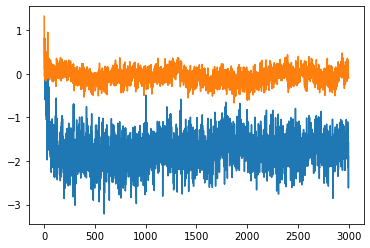

In [10]:
import matplotlib.pyplot as plt
plt.plot([math.log(i) for i in losses])
plt.plot([math.log(i) for i in val_losses])

In [14]:
# Load Trained Model
m = torch.load('26092023val_aenc.pt')
m.to(device)

Encoder(
  (embedding): Embedding(34, 32)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (self_attention): MultiHeadAttention(
    (W_q): Linear(in_features=32, out_features=32, bias=True)
    (W_k): Linear(in_features=32, out_features=32, bias=True)
    (W_v): Linear(in_features=32, out_features=32, bias=True)
    (W_o): Linear(in_features=32, out_features=32, bias=True)
  )
  (linear): Linear(in_features=3136, out_features=1, bias=True)
  (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [15]:
# Inference
def inference(model, loader):
    reals = []
    predicteds = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            property_prediction, loss = m(torch.tensor(batch.encsmiles), batch.y)
            for i,j in zip(property_prediction, batch.y):
                predicteds.append(i.item())
                reals.append(j.item())
    return reals, predicteds
    
train_real, train_pred = inference(m, loader)
test_real, test_pred = inference(m, test_loader)   

TRAIN - MSE: 0.19757708958290415 R2: 0.9544330276707752
TEST - MSE: 0.7597059537900144 R2: 0.8418293872833382


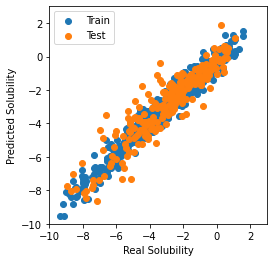

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Plotting
fig,ax = plt.subplots()
plt.scatter(train_real, train_pred)
plt.scatter(test_real, test_pred)

# Formatting
plt.xlabel("Real Solubility")
plt.ylabel("Predicted Solubility")
ax.legend(['Train', 'Test'])
ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
ax.set_xlim(-10,3)
ax.set_ylim(-10,3)

print('TRAIN - MSE:',mean_squared_error(train_real, train_pred),'R2:',r2_score(train_real, train_pred))
print('TEST - MSE:',mean_squared_error(test_real, test_pred),'R2:',r2_score(test_real, test_pred))